In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2

In [ ]:
import tensorflow_hub as hub

#특징 추출기 불러오기( 완전연결계층 X / input_shape 또한 따로 특정되지 않음 / 사전 훈련 x )
res_url = 'https://tfhub.dev/tensorflow/efficientnet/lite4/classification/2'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(res_url, 
                   output_shape=(1000,), 
                   trainable=False)
])

In [ ]:
feature_model.build([None, 224, 224, 3])
feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1000)              13118936  
Total params: 13,118,936
Trainable params: 0
Non-trainable params: 13,118,936
_________________________________________________________________


In [ ]:
feature_model.save('/content/drive/My Drive/efficientnet_f_model1.h5')

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 224
batch_size = 32

# 학습 및 검증 데이터용 ImageDataGenerator 생성해 놓기 
train_datagen = ImageDataGenerator(rescale=1./255., 
                                   horizontal_flip = False, 
                                   shear_range = 0,
                                   zoom_range = 0,
                                   width_shift_range = 0,
                                   height_shift_range = 0,
                                   validation_split = 0.25)

#검증데이터는 정규화 외에 따로 조정 없음 
valid_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.25)

#flow_from_directory()는 앞서 배운 flow()와 비슷, 단 경로를 통채로 가져올 수 있음 
train_generator = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/AI_SCHOOL/covid data/Data/train', #저장 경로 
                                                    subset = 'training',   
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/AI_SCHOOL/covid data/Data/train',
                                                    subset = 'validation',
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))


Found 3859 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.


In [ ]:
# 학습데이터의 3배정도 이미지가 보강되도록 한다.
import numpy as np

image_size = 224
batch_size = 32

batch_step = (3859 * 3) // batch_size #데이터 증폭 시켜 배치 스텝을 구해준다.(723회)
train_features = [] # 빈 리스트 생성 
train_Y = [] # 빈 리스트 생성 

for idx in range(batch_step): #스텝 만큼 반복
  if idx % 10 == 0: #만약 0 포함 100의 배수일때
    print(idx) #배치스텝 반환 (진행상황 표기)
  x, y = train_generator.next() #next()를 활용하여 train_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다.   
  train_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
  
  # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
  # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
  feature = feature_model.predict(x)
  train_features.extend(feature)

#array 전환 
train_features = np.array(train_features)
train_Y = np.array(train_Y)

print(train_features.shape)
print(train_Y.shape)
print(train_Y)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
(361, 1000)
(361, 3)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
valid_features = [] # 빈 리스트 생성 
valid_Y = [] # 빈 리스트 생성 

for idx in range(valid_generator.n): ## valid_generator.n = 2504 (검증데이터의 수)
  if idx % 100 == 0: #만약 0 포함 100의 배수일때
    print(idx) #배치스텝 반환 (진행상황 표기)
  x, y = valid_generator.next() #next()를 활용하여 valid_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다.   
  valid_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
  
  # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
  # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
  feature = feature_model.predict(x)
  valid_features.extend(feature)

#array 전환 
valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)

print(valid_features.shape)
print(valid_Y.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
(1285, 1000)
(1285, 3)


In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(256, activation= 'relu', input_shape = (1000,)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(3,activation='softmax')
])
model.compile(tf.optimizers.RMSprop(0.0001), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               256256    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 257,027
Trainable params: 257,027
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_features, train_Y, 
                    validation_data=(valid_features, valid_Y),
                    epochs = 30,
                    batch_size = 50)

Epoch 1/30
8/8 [==============================] - 0s 44ms/step - loss: 1.5978 - accuracy: 0.5152 - val_loss: 0.6244 - val_accuracy: 0.7525
Epoch 2/30
8/8 [==============================] - 0s 15ms/step - loss: 0.8085 - accuracy: 0.7285 - val_loss: 0.3449 - val_accuracy: 0.8685
Epoch 3/30
8/8 [==============================] - 0s 15ms/step - loss: 0.6699 - accuracy: 0.7784 - val_loss: 0.2915 - val_accuracy: 0.8988
Epoch 4/30
8/8 [==============================] - 0s 17ms/step - loss: 0.5064 - accuracy: 0.8283 - val_loss: 0.2640 - val_accuracy: 0.9012
Epoch 5/30
8/8 [==============================] - 0s 15ms/step - loss: 0.4961 - accuracy: 0.8227 - val_loss: 0.2507 - val_accuracy: 0.9074
Epoch 6/30
8/8 [==============================] - 0s 16ms/step - loss: 0.4493 - accuracy: 0.8283 - val_loss: 0.2467 - val_accuracy: 0.9074
Epoch 7/30
8/8 [==============================] - 0s 16ms/step - loss: 0.3737 - accuracy: 0.8476 - val_loss: 0.2367 - val_accuracy: 0.9160
Epoch 8/30
8/8 [===========

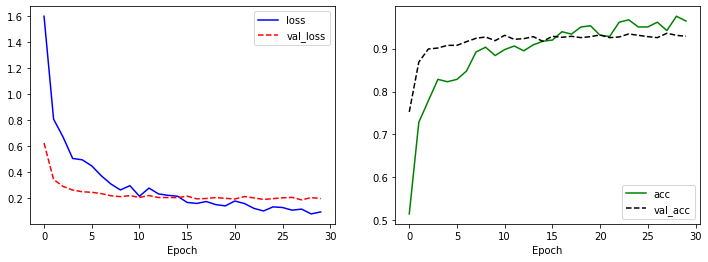

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
 
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label = 'acc')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [ ]:
results = model.evaluate(valid_features, valid_Y)
print('Test accuracy: ', results[1])

41/41 [==============================] - 0s 1ms/step - loss: 0.1985 - accuracy: 0.9284
Test accuracy:  0.928404688835144


In [ ]:
model.save('/content/drive/My Drive/efficientnet_model1.h5')

In [ ]:
# 오차 행렬
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_lr)
print("오차 행렬:\n", confusion)